In [1]:
# attempt to fit a disk model to NGC4261
import numpy as np
import astropy.units as u
from radiation import *
from agnpy.synchrotron import Synchrotron

import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import Distance
import sherpa
from sherpa.fit import Fit
from sherpa.data import Data1D, Data1DInt
from sherpa.models.basic import Polynom1D, Const1D, Gauss1D, RegriddableModel1D, Exp
from sherpa.plot import DataPlot, ModelPlot, JointPlot
from sherpa.plot import DelchiPlot, FitPlot, SplitPlot
from sherpa.plot import IntervalProjection
from sherpa.optmethods import NelderMead
from sherpa.stats import Cash, Chi2
from sherpa.astro import ui
from sherpa.models.parameter import Parameter

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
# general variables
sed_x_label = r"$\nu\,/\,{\rm Hz}$"
sed_y_label = r"$\nu F_{\nu}\,/\,({\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1})$"

In [3]:
# load the data and plot them
sed_table = Table.read("data/NGC4261_final_table.fits")
x = sed_table["col1"]
y = sed_table["col3"]
yerr = sed_table["col4"]

# define the data eliminating measurements with zero error
mask_error = yerr > 0
mask_lower_limit = y > 1e-14
mask = mask_error * mask_lower_limit
x_new = sed_table["col1"][mask]
y_new = sed_table["col3"][mask]
yerr_new = sed_table["col4"][mask]

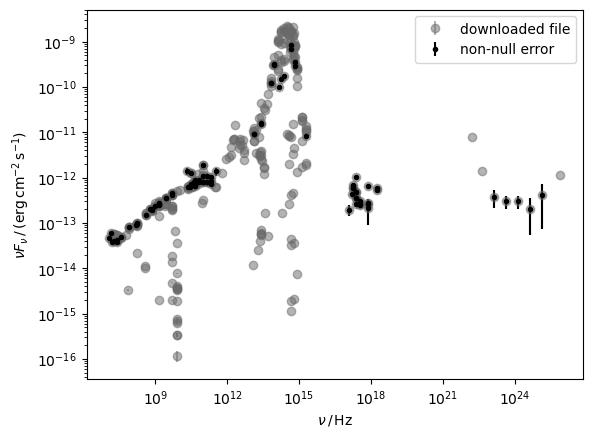

In [4]:
fig, ax = plt.subplots()
ax.errorbar(
    x,
    y,
    yerr=yerr,
    ls="",
    marker="o",
    color="dimgray",
    alpha=0.5,
    label="downloaded file"
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="non-null error"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.legend()
plt.show()

In [5]:
# define a new function fir the total flux
# that depends on a single array of frequencies
def nu_fnu_disk(nu, m, m_dot, d_L, norm=1):
    """Compute the total flux.
    I allow an arbitrary scaling via norm parameter, default is 1.
    """
    T_calc = compute_T_e_equilibirum(m, m_dot)

    # compute parameters
    _x_m = x_m_appendix_B(m_dot)
    _alpha_c = alpha_c(theta_from_T(T_calc * u.K), m_dot)
    # compute "break" frequency
    nu_p = vp(_x_m, m_dot, m, theta_from_T(T_calc * u.K)).value

    # let us use a switch on the three emission mechanisms
    luminosity = np.where(
        nu <= nu_p, 
        L_synch(nu, m, m_dot, _x_m, T_calc),
        L_bremms(nu, T_calc, m, m_dot) + L_compton(nu, nu_p, _alpha_c, m, m_dot, _x_m, T_calc)
    )

    sed = nu *  luminosity / (4 * np.pi * d_L**2)
    return norm * sed

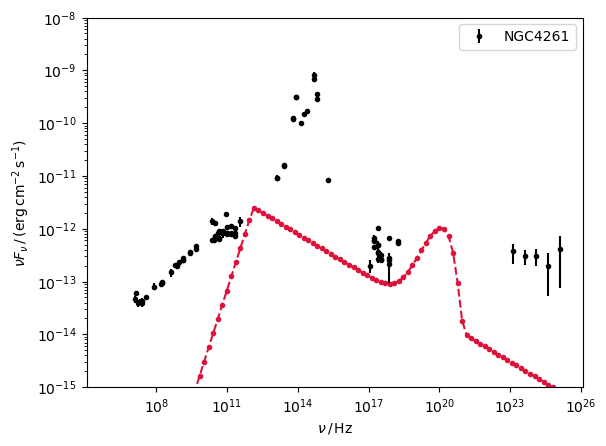

In [6]:
# let us overplot just one disk model to compare with the data
# sort of an initial guess
m = 5.2e8
m_dot = 1e-3
norm = 10
d_L = Distance(z=0.00731).to_value("cm")

# compute the model over an arbitrary array of frequencies
nu = np.logspace(6, 25, 100)

# plot now both the model and the points with errors
fig, ax = plt.subplots()
ax.plot(
    nu,
    nu_fnu_disk(nu, m, m_dot, d_L, norm),
    color="crimson",
    ls="--",
    marker="."
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="NGC4261"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.legend()
ax.set_ylim([1e-15, 1e-8])
plt.show()

In [7]:
class ThermalDiskEmission(RegriddableModel1D):
    def __init__(self, name='disk emission'):

        self.log10_m = Parameter(name, 'log10_m', 8, min=2, max=12)
        self.log10_m_dot = Parameter(name, 'log10_m_dot', -3, min=-6, max=-1)
        self.norm = Parameter(name, 'norm', 10)
        self.d_L = Parameter(name, 'd_L', 1e26)
        
        return RegriddableModel1D.__init__(self, name, (self.log10_m, self.log10_m_dot, self.norm, self.d_L))

    def calc(self, pars, x, *args, **kwargs):
        """Calculate the model"""
        log10_m = pars[0]
        log10_m_dot = pars[1]
        norm = pars[2]
        d_L = pars[3]
        # convert back logarythmic quantities
        m = 10**(log10_m)
        m_dot = 10**(log10_m_dot)
        return nu_fnu_disk(nu=x, m=m, m_dot=m_dot, d_L=d_L, norm=norm)

In [10]:
class NonThermalJetEmission(RegriddableModel1D):
    """Wrapper of agnpy's synchrotron and SSC classes. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    def __init__(self, name="ssc"):

        # EED parameters
        self.log10_k_e = Parameter(name, "log10_k_e", -2.0, min=-20.0, max=10.0)
        self.p1 = Parameter(name, "p1", 2.1, min=-2.0, max=5.0)
        self.p2 = Parameter(name, "p2", 3.1, min=-2.0, max=5.0)
        self.log10_gamma_b = Parameter(name, "log10_gamma_b", 3, min=1, max=6)
        self.log10_gamma_min = Parameter(name, "log10_gamma_min", 1, min=0, max=4)
        self.log10_gamma_max = Parameter(name, "log10_gamma_max", 5, min=4, max=8)
        # source general parameters
        self.z = Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = Parameter(name, "d_L", 1e27, min=1e25, max=1e33, units="cm")
        # emission region parameters
        self.delta_D = Parameter(name, "delta_D", 10, min=0, max=40)
        self.log10_B = Parameter(name, "log10_B", -2, min=-4, max=2)
        self.t_var = Parameter(
            name, "t_var", 600, min=10, max=np.pi * 1e7, units="s"
        )

        RegriddableModel1D.__init__(
            self,
            name,
            (
                self.log10_k_e,
                self.p1,
                self.p2,
                self.log10_gamma_b,
                self.log10_gamma_min,
                self.log10_gamma_max,
                self.z,
                self.d_L,
                self.delta_D,
                self.log10_B,
                self.t_var,
            ),
        )

    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (
            log10_k_e,
            p1,
            p2,
            log10_gamma_b,
            log10_gamma_min,
            log10_gamma_max,
            z,
            d_L,
            delta_D,
            log10_B,
            t_var,
        ) = pars

        # add units, scale quantities
        x *= u.Hz
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        d_L *= u.cm
        R_b = c.to_value("cm s-1") * t_var * delta_D / (1 + z) * u.cm

        sed_synch = Synchrotron.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
        )

        return sed_synch

In [15]:
# let us define an instance of the model

# distance of the source, not to be fitted
d_L = Distance(z=0.00731).to_value("cm")

model = ThermalDiskEmission()
model.d_L = d_L
model.d_L.freeze()
model

<ThermalDiskEmission model instance 'disk emission'>

In [16]:
data = Data1D('fit example', x_new, y_new, yerr_new)
# ignore black body emission from the Galaxy
nu_min_fit = 1e12
nu_max_fit = 1e16
data.ignore(nu_min_fit, nu_max_fit)
fit = Fit(data, model, stat=Chi2())
res = fit.fit()
print(res.format())

Method                = levmar
Statistic             = chi2
Initial fit statistic = 1.11353e+07
Final fit statistic   = 1.92771e+06 at function evaluation 82
Data points           = 74
Degrees of freedom    = 71
Probability [Q-value] = 0
Reduced statistic     = 27150.9
Change in statistic   = 9.20754e+06
   disk emission.log10_m   9.36405      +/- 0.000592368 
   disk emission.log10_m_dot   -2.95212     +/- 0.0020743   
   disk emission.norm   29.5936      +/- 0.151356    


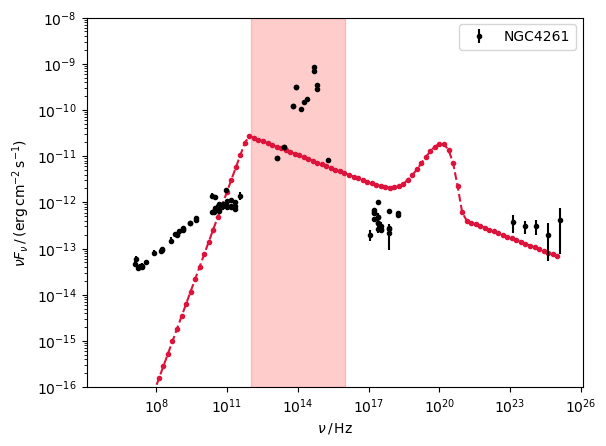

In [17]:
fig, ax = plt.subplots()
best_fit_m = 10 ** model.log10_m.val
best_fit_m_dot = 10 ** model.log10_m_dot.val
best_fit_model = nu_fnu_disk(
    nu,
    best_fit_m,
    best_fit_m_dot,
    model.d_L.val,
    model.norm.val
)
ax.plot(
    nu,
    best_fit_model,
    color="crimson",
    ls="--",
    marker="."
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="NGC4261"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_ylim([1e-16, 1e-8])
ax.fill_betweenx([1e-16, 1e-8], nu_min_fit, nu_max_fit, color="red", alpha=0.2)
ax.legend()
plt.show()